# Frozen Lake 2 - Q Learning
---

In this assignment, you are going to develop a policy for Frozen Lake using Q learning.

In [1]:
import gymnasium as gym
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

## Part 1. (80/100) Q Learning

In the class below, fill in the code of update.

In [2]:
class QLearning:
    def __init__(
        self,
        env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The environment 
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env 
        # lambda is called for missing key, which gives a zero vector
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
    def get_action(self, obs: tuple[int, int], ignore_epsilon = False) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        
        if ignore_epsilon or np.random.random() >= self.epsilon:
            # with probability (1 - epsilon) act greedily (exploit)
            return int(np.argmax(self.q_values[obs]))        
        else:
            # with probability epsilon return a random action to explore the environment
            return self.env.action_space.sample()

    def update(
        self,
        obs: tuple[int, int],
        action: int,
        reward: int,
        terminated: bool,
        next_obs: tuple[int, int],
    ):
        """Updates the Q-value of an action."""
        
        new_q_value = (not terminated) * np.max(self.q_values[next_obs])
 
        """
        Update the q value using formula: 
        TD_value = reward + discount_factor * new_q_value - Q(obs, action)
        Q(obs, action) = Q(obs, action) + learning_rate * TD_value. 
        
        where q value is a dictionary and q value at obs and action Q(obs, action)
        can be accessed using self.q_values[obs][action]
        """
        # Your code goes here:
        TD_value = reward + self.discount_factor * new_q_value - self.q_values[obs][action]
        self.q_values[obs][action] = self.q_values[obs][action] + self.lr * TD_value

       
    
    

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


### Agent

We will choose the values for a group of parameters to enale an agent. In this assignment, you only need to set two parameters:

- learning_rate: learning the new value quick or slow. You can choose a value between 0 and 1, such as 0.01, 0.1, 0.2, 0.3, etc.
- n_episodes: the total number of episode for training. You can choose any positive integers such as 50, 100, 1000, 1 million.

In [3]:
# hyperparameters
learning_rate = 0.1
n_episodes = 10000

The code below defines the environment:

In [4]:
# environment 
env_slippery = gym.make("FrozenLake-v1", render_mode=None) 

The code below defines the agent:

In [5]:
start_epsilon = 1.0 # initial value of epsilon
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.0 # last value of epsilon

agent_q_learning = QLearning(
    env = env_slippery,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

### Training

We will call get_actions and update to interact with the agent in every loop when the agent plays the game. You do not need to change anything in the code.

In [6]:
def training(env, agent, n_episodes):
    training_rewards = []
    training_lengths = []
    for episode in tqdm(range(n_episodes)):
        obs, info = env.reset()
        done = False

        training_reward = 0
        training_length = 0

        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)

            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)

            # update if the environment is done      
            done = terminated 
            # done = terminated or truncated
            obs = next_obs

            training_reward += reward
            training_length += 1

        agent.decay_epsilon()

        training_rewards.append(training_reward)
        training_lengths.append(training_length)
        
    return training_rewards, training_lengths

In [7]:
training_rewards1, training_lengths1 = training(env_slippery, agent_q_learning, n_episodes)

100%|██████████| 10000/10000 [00:02<00:00, 4675.82it/s]


### Visualize the training results

You do not need to do anything here. Run the code below to see the average episode rewards and lengths over the training iterations. You should see an output like this:

![](https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/assignments/frozen_lake2/Q_Learning_results.png)

In [8]:
def visualizing_results(training_rewards, training_lengths):
    
    rolling_length = 100 # number of episodes to average 

    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    axs[0].set_title("Episode rewards")
    # compute and assign a rolling average of the data to provide a smoother graph
    reward_moving_average = (
        # rolling window: https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
        np.convolve(
            np.array(training_rewards).flatten(), np.ones(rolling_length), mode="valid"  # 
        )
        / rolling_length
    )
    axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

    axs[1].set_title("Episode lengths")
    length_moving_average = (
        np.convolve(
            np.array(training_lengths).flatten(), np.ones(rolling_length), mode="same"  # 
        )
        / rolling_length
    )
    axs[1].plot(range(len(length_moving_average)), length_moving_average)

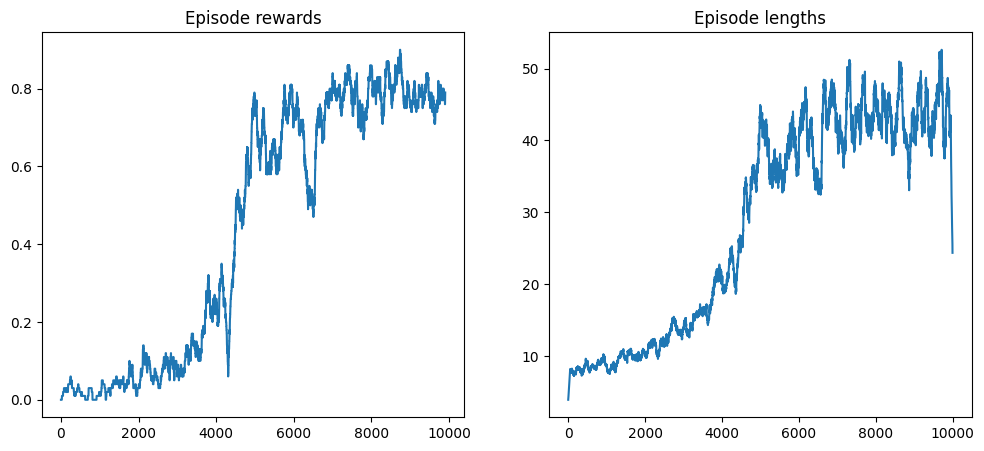

In [9]:
visualizing_results(training_rewards1, training_lengths1)

### Test the model

Run the code below to test the agent you trained using Q learning. You should see the winning chance above 70%. 

In [10]:
def testing_model(env, agent):
    n_games = 1000
    average_rewards, total_rewards = 0, 0

    for _ in range(n_games):
        state, info = env.reset()
        done = False

        while not done:
            action = agent.get_action(state, ignore_epsilon = True)

            state, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated
            if done:
                total_rewards += reward
    env.close()

    average_rewards = total_rewards / n_games
    print(f"The winning chance is {average_rewards}.")

In [11]:
testing_model(env_slippery, agent_q_learning)

The winning chance is 0.73.


In [12]:
env_slippery.close()

## Part 2. (20/100) Approximate Q Learning

Please fill in the code below in update() to implement approximate q learning. 

In [13]:
class Approx_QLearning:
    def __init__(
        self,
        actions,
        feature_extractor,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.actions = actions
        self.feature_extractor = feature_extractor
        
        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.weights = {}  # key: feature index, value: weight
        
    def get_Q_value(self, state, action, debug=False):
        """Estimate Q(s, a) = w · f(s, a)"""
        features = self.feature_extractor(state, action)
        return sum(self.weights.get(f, 0.0) * v for f, v in features.items())
        
    def get_action(self, obs: tuple[int, int], ignore_epsilon = False) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        
        if ignore_epsilon or np.random.random() > self.epsilon:
            # with probability (1 - epsilon) act greedily (exploit)
            q_values = [(self.get_Q_value(obs, a), a) for a in self.actions]
            max_q = max(q_values)[0]
            best_actions = [a for q, a in q_values if q == max_q]
            return random.choice(best_actions)
        else:
            return random.choice(self.actions)

    def update(
        self,
        state: tuple[int, int],
        action: int,
        reward: int,
        terminated: bool,
        next_state: tuple[int, int],
        debug = False
    ):
        # Compute features and current Q estimate
        features = self.feature_extractor(state, action)
        current_q = self.get_Q_value(state, action)

        # Compute max Q for next state
        next_q = (not terminated) * max(self.get_Q_value(next_state, a) for a in self.actions)

        # Your code goes here:
        
        # Compute TD error
        # TD_value = reward + self.discount_factor * new_q_value - self.q_values[obs][action]
        # self.q_values[obs][action] = self.q_values[obs][action] + self.lr * TD_value
        
        TD_error = reward + self.discount_factor * next_q - current_q
        


        # Update weights using SGD
        for feature, old_weight in features.items():
            self.weights[feature] = self.weights.get(feature, 0.0) + self.lr * TD_error * old_weight

            
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)


### Features

We will train the Approximate Q-Learning algorithm on the non-slippery version of FrozenLake, meaning the environment is deterministic. This choice is made because in FrozenLake, training in a stochastic setting is difficult due to:

1. the sparse and delayed reward structure.
2. no memory in the path.
3. the calculation of the feature may not be precise. 

Although we can solve the deterministic FrozenLake using Breadth-First Search (BFS) directly, we will still use Approximate Q-Learning to test and evaluate our implementation.

In the code below, design the features. Please keep in mind that the environment is **derterminstic**. 

In [14]:
grid_size = 4
holes = [5,7,11,12]
goal = 15

"""
state is a position id from board:
0  1  2  3
4  5  6  7
8  9  10 11
12 13 14 15

action is one of: 
         3 up
0 Left         2 right 
         1 down
         
The id of holes and goal are provided above.

// manhattan distance to the goal
// probability of going to the hole : agent facing hole not facing

// use next state instead of current state:
	// if next state is hole or not
    // manhattan distance to goal
    // if next state is wall or not
    // if next state is goal or not
    
"""

def feature_extractor(state, action):
    # key is feature id. value if the feature value.
    features = {}
    
    # You can define as many features as you want using state and action. 
    # Your code goes here:
    
	# goal = 1 | hole = 2
    
    
    coordinates = {}
    
    position = 0
    for i in range(4):
        for j in range(4):
            coordinates[position] = (i,j)
            position += 1
    
    def manhattan(pos_x, pos_y):
            return 0 if pos_x not in range(0,15) or pos_y not in range(0,15) else abs(coordinates[pos_x][0] - coordinates[pos_y][0]) + abs(coordinates[pos_x][1] - coordinates[pos_y][1])
    
    if action == 2:
        features[1] = 10 if state+1 == 15 else 0.1
        features[2] = -10 if state+1 in holes else 0.1
        # features[3] = 5 if manhattan(state+1, 15) < manhattan(state, 15) else -1
    elif action == 1:
        features[1] = 10 if state+4 == 15 else 0.1
        features[2] = -10 if state+4 in holes else 0.1
        # features[3] = 5 if manhattan(state+4, 15) < manhattan(state, 15) else -1
    elif action == 0:
        features[1] = 0.1
        features[2] = -10 if state-1 in holes else 0.1
        # features[3] = 5 if manhattan(state-1, 15) < manhattan(state, 15) else -1
    else:
        features[1] = 0.1
        features[2] = -10 if state-4 in holes else 0.1
        # features[3] = 5 if manhattan(state-4, 15) < manhattan(state, 15) else -1
    
    
    
    

    # Normalize the feature values.
    s = sum(features.values())
    for f in features:
        features[f] = features[f]/s
        
    return features


### Agent

Define two parameters below:

In [15]:
# hyperparameters
learning_rate = 0.1
n_episodes = 10000

The code below defines the environment:

In [33]:
# environment 
env_not_slippery = gym.make("FrozenLake-v1", is_slippery=False)  # disable built-in slippery logic

The code below defines the agent:

In [34]:
# hyperparameters
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.0

agent_approx = Approx_QLearning(
    actions = [0,1,2,3],
    feature_extractor = feature_extractor,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    discount_factor = 1
)

### Training


In [35]:
training_rewards2, training_lengths2 = training(env_not_slippery, agent_approx, n_episodes)

100%|██████████| 10000/10000 [00:07<00:00, 1288.31it/s]


### Visualizing Training Results

You are expect to see the output like this:

![](https://cs.westminstercollege.edu/~jingsai/courses/CMPT301/assignments/frozen_lake2/Approx_Q_Learning_results.png)

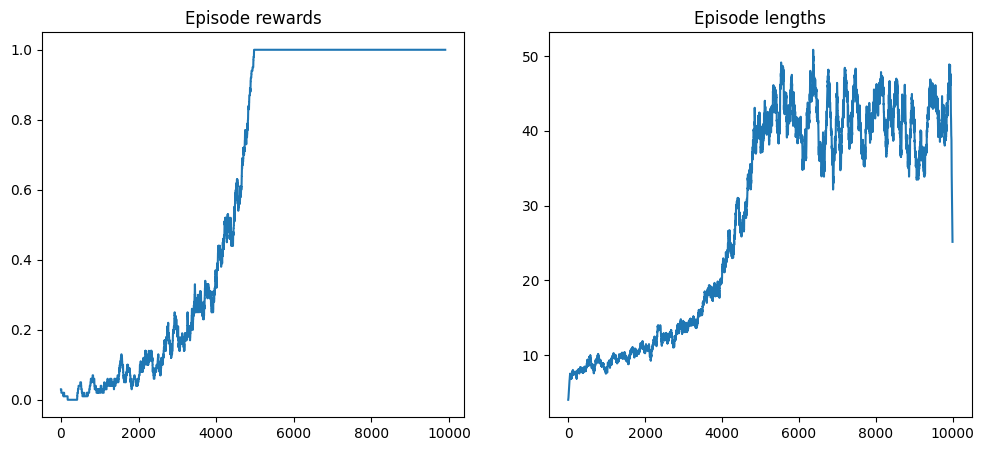

In [36]:
visualizing_results(training_rewards2, training_lengths2)

### Test the model

Run the code below to test your agent. The winning chance should near 100%.

In [39]:
testing_model(env_not_slippery, agent_approx)

The winning chance is 0.932.


In [40]:
env_not_slippery.close()